# Vorhersage von Sportergebnissen mittels probabilistischer Programmierung


In [1]:
import numpy as np
import pandas as pd

import pymc as pm

import scipy
# for plotting
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline


# directed graphical models as pretty figures
import daft
from collections import OrderedDict


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# kwargs dict for histograms 
plot_hist_param = {"facecolor":'#2ab0ff', "edgecolor":'#169acf', "linewidth":0.5, "density":True}

## Model 1

Funktion zur plotten des einfaches Modells mit der Bibliothek `daft`.

In [3]:

def plot_model(save=True):
    pgm = daft.PGM([7.3, 3.05], 
                   grid_unit=2., node_unit=1., 
                   origin=[1., 0.], aspect=1.,
                  dpi=200)
    pgm.add_node(daft.Node("o_i", r"oA", 1.5, 2))
    pgm.add_node(daft.Node("d_j", r"dB", 1.5, 1))
    
    pgm.add_node(daft.Node("o_j", r"oB", 6.5, 1))
    pgm.add_node(daft.Node("d_i", r"dA", 6.5, 2))
    
    #pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
    pgm.add_node(daft.Node("diffAB", r"$\Delta$AB", 2.5, 1.5))
    pgm.add_node(daft.Node('none_AB', '', 2.5, 1.5, scale=0.85, aspect=1))
    pgm.add_node(daft.Node("gAB", r"gAB", 3.5, 1.5, observed=True))
    
    pgm.add_node(daft.Node("diffBA", r"$\Delta$BA", 5.5, 1.5))
    pgm.add_node(daft.Node('none_BA', '', 5.5, 1.5, scale=0.85, aspect=1))
    pgm.add_node(daft.Node("gBA", r"gBA", 4.5, 1.5, observed=True))
    
    
    # Add in the edges.

    pgm.add_edge("o_i", "diffAB")
    pgm.add_edge("d_j", "diffAB")
    pgm.add_edge("diffAB", "gAB")
    pgm.add_edge("o_j", "diffBA")
    pgm.add_edge("d_i", "diffBA")
    pgm.add_edge("diffBA", "gBA")
    #if save:
    #    pgm.savefig('pics/figure_6.png')
    pgm.render()
    
    
plot_model()

### Load Data


Split the data in training and test set at a fixed date.



In [4]:
# load the data from https://www.football-data.co.uk/germanym.php
# and copy it to a file
filepath = "~/chris/data/bundesliga/D1.csv"
df = pd.read_csv(filepath, sep=',')
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
d1 = df
d1.head(3)

Div       Date   Time       HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  \
0  D1 2022-08-05  19:30  Ein Frankfurt  Bayern Munich     1     6   A     0   
1  D1 2022-08-06  14:30       Augsburg       Freiburg     0     4   A     0   
2  D1 2022-08-06  14:30         Bochum          Mainz     1     2   A     1   

   HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
0     5  ...     3.03  1.25      2.00      1.93   2.00   1.93     2.01   
1     0  ...     1.95  0.25      2.04      1.89   2.04   1.88     2.08   
2     1  ...     1.97  0.25      1.95      1.98   1.95   1.97     1.99   

   MaxCAHA  AvgCAHH  AvgCAHA  
0     2.00     1.93     1.94  
1     1.89     2.03     1.84  
2     1.99     1.93     1.93  

[3 rows x 105 columns]

In [5]:
# all teams as numpy arrays

t1 = d1.HomeTeam.unique().astype('U')
t2 = d1.AwayTeam.unique().astype('U')
teams = np.unique(np.concatenate((t1,t2)))

print(teams)
assert len(teams) == 18
nb_teams = len(teams)

['Augsburg' 'Bayern Munich' 'Bochum' 'Dortmund' 'Ein Frankfurt' 'FC Koln'
 'Freiburg' 'Hertha' 'Hoffenheim' 'Leverkusen' "M'gladbach" 'Mainz'
 'RB Leipzig' 'Schalke 04' 'Stuttgart' 'Union Berlin' 'Werder Bremen'
 'Wolfsburg']


In [6]:
# get data record from team indices
def getResults(homeTeamIndex, awayTeamIndex, df = d1):
    homeTeam = teams[homeTeamIndex]
    awayTeam = teams[awayTeamIndex]
    return df.query("HomeTeam == '" + homeTeam + "' and AwayTeam == '" + awayTeam + "'" )

getResults(0, 1) 

Div       Date   Time  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
55  D1 2022-09-17  14:30  Augsburg  Bayern Munich     1     0   H     0     0   

    ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
55  ...      4.2  2.25       2.0       1.9   2.01    1.9     2.14     1.95   

    AvgCAHH  AvgCAHA  
55     1.97     1.88  

[1 rows x 105 columns]

In [7]:
# build team lexicon
# map from team-index to Name 
team_indices = OrderedDict()
for i, t in enumerate(teams):
     team_indices[t] = i

In [8]:
GOALS_HOME='FTHG'
GOALS_AWAY='FTAG'

def get_goal_results(d=d1, gh=GOALS_HOME):
    result = list()
    for r in d.iterrows():
        home_team = r[1].HomeTeam
        away_team = r[1].AwayTeam
        goals=r[1][gh]
        result.append((team_indices[home_team], team_indices[away_team], goals))
    return result

home_goals_ = get_goal_results(gh=GOALS_HOME)
away_goals_ = get_goal_results(gh=GOALS_AWAY)

# list of tuples
# (home_team-index, away_team_index, scored_goals of home team resp. away team)
home_goals_[:3]

[(4, 1, 1), (0, 6, 0), (2, 11, 1)]

In [9]:
low = 10e-8 # Constant

In [10]:
def vectorized_data(home_goals_, away_goals_):
    home_id = np.array([hg[0] for hg in home_goals_])
    away_id = np.array([hg[1] for hg in home_goals_])
    home_goals = np.array([hg[2] for hg in home_goals_])
    away_goals = np.array([ag[2] for ag in away_goals_])
    toto = np.where(home_goals == away_goals, 0,
                        np.where(home_goals > away_goals, 1, 2))
    return home_id, away_id, home_goals, away_goals, toto

home_id, away_id, home_goals, away_goals, toto = vectorized_data(home_goals_, away_goals_)

#### PyMC Model 1

In [11]:
model1 = pm.Model()
min_mu = 0.0001
average_goals = 3. # average nb of goals in a game
with model1:
    offence = pm.Normal("offence", tau=1., mu=average_goals/2, shape=nb_teams)
    defence = pm.Normal("defence", tau=1., mu=0., shape=nb_teams)
    
    offence_home = offence[home_id]
    defence_home = defence[home_id]
    offence_away = offence[away_id]
    defence_away = defence[away_id]

    mu_home = offence_home - defence_away
    mu_away = offence_away - defence_home
    # note: use exponent in practice instead of switch
    mu_home = pm.math.switch(mu_home > min_mu, mu_home, min_mu)
    mu_away = pm.math.switch(mu_away > min_mu, mu_away, min_mu)
    
    pm.Poisson("home_goals", observed=home_goals, mu=mu_home)
    pm.Poisson("away_goals", observed=away_goals, mu=mu_away)


In [12]:
nb_samples=2000
### tune adds additional number of samples.
### after sampling these additional samples get discarded
### as the very first samples are very inaccurate
tune = nb_samples//10

with model1:
#with model1_home_advantage:
    trace = pm.sample(draws=nb_samples, tune=tune) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offence, defence]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 4 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
posterior = trace.posterior.stack(sample=['chain', 'draw'])
offence = posterior["offence"]
defence = posterior["defence"]
#home_advantage = posterior["home_advantage"]

In [14]:
print('Mean offence strenght per team:')
for t in teams: 
    i = team_indices[t]
    print(t, " ", offence[i].mean().values)

Mean offence strenght per team:
Augsburg   1.3666312068313027
Bayern Munich   2.576052777493621
Bochum   1.1894463303768108
Dortmund   2.3874901957847117
Ein Frankfurt   1.6974519371350725
FC Koln   1.4051826596724737
Freiburg   1.469237266200989
Hertha   1.2944418136252935
Hoffenheim   1.4079957211547574
Leverkusen   1.6587605487843684
M'gladbach   1.5682354513016319
Mainz   1.5940576472289132
RB Leipzig   1.8397127387105132
Schalke 04   0.9795476179611857
Stuttgart   1.3128852824704924
Union Berlin   1.5017130635286593
Werder Bremen   1.4972841018965337
Wolfsburg   1.6381638973629025


In [15]:
### mean of offence strength
print('Mean defence strenght per team:')
for t in teams: 
    i = team_indices[t]
    print(t, "\t", defence[i].mean().values)

Mean defence strenght per team:
Augsburg 	 -0.31093646106538697
Bayern Munich 	 0.37204159570509204
Bochum 	 -0.5378330599202714
Dortmund 	 0.17270792481520778
Ein Frankfurt 	 -0.0029139532691576917
FC Koln 	 -0.04928753978712301
Freiburg 	 0.37048768967747797
Hertha 	 -0.5001781498904372
Hoffenheim 	 -0.1776932051265942
Leverkusen 	 0.07122789132378105
M'gladbach 	 -0.08551010030537305
Mainz 	 -0.1193570538947804
RB Leipzig 	 0.19506308743037953
Schalke 04 	 -0.47109023003167416
Stuttgart 	 -0.12534629396418714
Union Berlin 	 0.33851378360179446
Werder Bremen 	 -0.30730446099555936
Wolfsburg 	 0.17082863027457001


In [16]:
show_teams = 5
#show_teams = nb_teams

bins=40
fig, axes = plt.subplots(nrows=show_teams+1, ncols=2, figsize=(10, (show_teams+1) * 2 ))

for x, (t, i) in enumerate(team_indices.items()):
    title = "Offence of " + t
    axes[i, 0].set_title(title)
    axes[i, 0].hist(offence[i], bins=bins, range=(0,4.2), **plot_hist_param)
    
    axes[i, 1].hist(defence[i], bins=bins, range=(-2.,2.2), **plot_hist_param)
    title = "Defence of " + t
    axes[i, 1].set_title(title)
    if x >= show_teams:
        break
    
#fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=.5)
fig.tight_layout()
#plt.savefig('pics/figure_7.png')

In [17]:
#pm.predictions_to_inference_data
with model1:
    samples = pm.sample_posterior_predictive(trace)

Sampling: [away_goals, home_goals]


In [18]:
def get_diffs(team_1, team_2):
    diff_ij = offence[team_1] - defence[team_2]
    diff_ji = offence[team_2] - defence[team_1]
    return diff_ij, diff_ji

In [19]:
def get_probs_winner(teamIndex1, teamIndex2):

    diff_ij, diff_ji = get_diffs(teamIndex1, teamIndex2)    
    diff_ij[diff_ij < min_mu] = min_mu
    diff_ji[diff_ji < min_mu] = min_mu
    
    goals_of_team_1 = np.array([np.random.poisson(r) for r in diff_ij])
    goals_of_team_2 = np.array([np.random.poisson(r) for r in diff_ji])
        
    team1_wins = goals_of_team_1 > goals_of_team_2
    team2_wins = goals_of_team_1 < goals_of_team_2    
    tie = goals_of_team_1 == goals_of_team_2
    
    p1 = team1_wins.mean()
    p2 = team2_wins.mean()
    tie = tie.mean()
    np.testing.assert_almost_equal(1., p1 +tie +p2)
    return tie, p1, p2

In [20]:
def get_goal_distribution(diff, max_goals=20):
    poisson_goals = np.zeros(max_goals)
    k=np.arange(0, max_goals)
    for lambda_ in diff:
        lambda_ = max(low, lambda_)
        poisson_goals += scipy.stats.poisson.pmf(k, lambda_)
    poisson_goals = poisson_goals / poisson_goals.sum()
    return poisson_goals

In [21]:
def plot_goal_diffs(team_1, team_2, max_goals=8):
    
    diff_ij, diff_ji = get_diffs(team_1, team_2)
    poisson_goals_1 = get_goal_distribution(diff_ij, max_goals)
    poisson_goals_2 = get_goal_distribution(diff_ji, max_goals)
    # Create the figure and axes objects, specify the size and the dots per inches 
    fig, ax = plt.subplots(figsize=(6, 4), dpi = 96)

    # Plot bars
    x=np.arange(0, max_goals)
    width = 0.4
    bar1 = ax.bar(x-width/2, poisson_goals_1 , width=width, alpha = 0.9, label="Tore von "+teams[team_1])# Add in title and subtitle
    bar2 = ax.bar(x+width/2, poisson_goals_2 , width=width, alpha = 0.9, label="Tore von "+teams[team_2])# Add in title and subtitle
    ax.set_xticks(x, x)
    ax.text(x=0.12, y=.93, s="Torvorhersage", transform=fig.transFigure, ha='left', fontsize=10, weight='bold', alpha=1.)
    ax.text(x=0.12, y=.90, s=teams[team_1]+ " gegen " + teams[team_2], transform=fig.transFigure, ha='left', fontsize=8, alpha=1.)
    ax.legend()
    # figure for book 
    #plt.savefig('pics/figure_8    defence_dim_0  int64 1 (8000,).png')
    

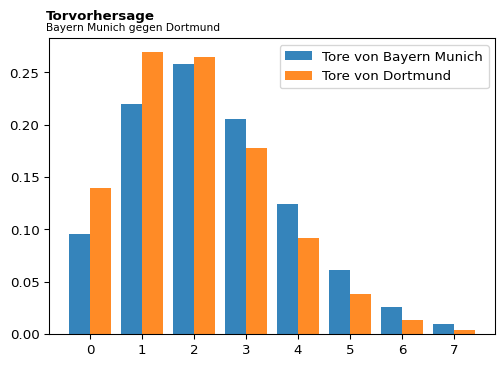

In [22]:
teamIndex1, teamIndex2 = 1, 3
plot_goal_diffs(teamIndex1, teamIndex2)

In [23]:
get_probs_winner(teamIndex1, teamIndex2)

(0.178875, 0.48625, 0.334875)

# Model 2

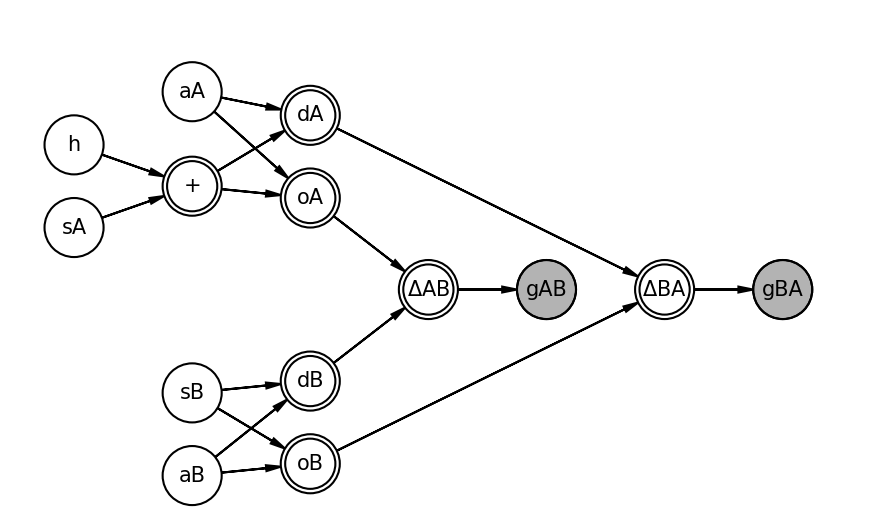

In [24]:
import daft

y_shift = 0.75

def plot_model(home=False, result=False):
    
    
    if home:
        pgm = daft.PGM([7.3, 4.2], 
                   grid_unit=2., node_unit=1., 
                   origin=[0., 0.], aspect=1.,
                  dpi=150)
        
        pgm.add_node(daft.Node("sA_", r"sA", .5, 1.65 + y_shift ))
        pgm.add_node(daft.Node("h", r"h", .5, 2.35 + y_shift))
        pgm.add_node(daft.Node("sA", r"+", 1.5, 2 + y_shift))
        pgm.add_node(daft.Node('none_+', '', 1.5, 
                               2 + y_shift, scale=0.85, aspect=1))
        pgm.add_edge("sA_", "sA")
        pgm.add_edge("h", "sA")
    else:
        pgm = daft.PGM([6.3, 4.2], 
                   grid_unit=2., node_unit=1., 
                   origin=[1., 0.], aspect=1.,
                  dpi=150)
        pgm.add_node(daft.Node("sA", r"sA", 1.5, 2.8))
    
    pgm.add_node(daft.Node("aA", r"aA", 1.5, 2.8 + y_shift))
    
    pgm.add_node(daft.Node("aB", r"aB", 1.5, 0.3))
    pgm.add_node(daft.Node("sB", r"sB", 1.5, 1.))
    
    #pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
    pgm.add_node(daft.Node("oA", r"oA", 2.5, 1.9+ y_shift))
    pgm.add_node(daft.Node('none_oA', '', 2.5, 1.9+ y_shift, scale=.85, aspect=1))
    pgm.add_node(daft.Node("dA", r"dA", 2.5, 2.6+ y_shift))
    pgm.add_node(daft.Node('none_dA', '', 2.5, 2.6+ y_shift, scale=0.85, aspect=1))
    
    pgm.add_node(daft.Node("dB", r"dB", 2.5, 1.1))
    pgm.add_node(daft.Node('none_dB', '', 2.5, 1.1, scale=0.85, aspect=1))
    
    pgm.add_node(daft.Node("oB", r"oB", 2.5, 0.4))
    pgm.add_node(daft.Node('none_oB', '', 2.5, 0.4, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("diffAB", r"$\Delta$AB", 3.5, 1.5+ y_shift/2))    
    pgm.add_node(daft.Node('none_AB', '', 3.5, 1.5+ y_shift/2, scale=0.85, aspect=1))
    
    pgm.add_node(daft.Node("diffBA", r"$\Delta$BA", 5.5, 1.5+ y_shift/2))    
    pgm.add_node(daft.Node('none_BA', '', 5.5, 1.5+ y_shift/2, scale=0.85, aspect=1))
    
    pgm.add_node(daft.Node("gAB", r"gAB", 4.5, 1.5+ y_shift/2, observed=True))
    pgm.add_node(daft.Node("gBA", r"gBA", 6.5, 1.5+ y_shift/2, observed=True))
    
    # Add in the edges.
    pgm.add_edge("sA", "oA")
    pgm.add_edge("aA", "oA")
    pgm.add_edge("sA", "dA")
    pgm.add_edge("aA", "dA")
    
    pgm.add_edge("sB", "oB")
    pgm.add_edge("aB", "oB")
    pgm.add_edge("sB", "dB")
    pgm.add_edge("aB", "dB")
    
    pgm.add_edge("oA", "diffAB")
    pgm.add_edge("dB", "diffAB")
    pgm.add_edge("diffAB", "gAB")
    pgm.add_edge("oB", "diffBA")
    pgm.add_edge("dA", "diffBA")
    pgm.add_edge("diffBA", "gBA")
    
    if result:
        pgm.add_node(daft.Node("w", r"$\bf{w}$", 1.5, 1.5 + y_shift/2 ) )
        pgm.add_node(daft.Node("result", r"result", 2.5, 1.5+ y_shift/2, observed=True))
        pgm.add_edge("w", "result")
        pgm.add_edge("sA", "result")
        pgm.add_edge("sB", "result")
        
    # And plates.
    pgm.render()
    
    
#plot_model(True, True)
plot_model(True, False)
#plot_model(False, False)

In [25]:

model2 = pm.Model()
with model2:
    score = pm.Normal("score", tau=1., mu=0., shape=nb_teams)
    offence_defence_diff = pm.Normal("offence_defence_diff", 
                                tau=1., mu=average_goals/2., 
                                shape=nb_teams)
    
    home_advantage = pm.Normal("home_advantage", tau=10., mu=.0)

    # softmax regression weights for winner predicton:
    weights = pm.Normal("weights", mu=(0., .25, -0.25), tau=100., shape=(3))    

    score_home = score[home_id] + home_advantage
    offence_home = score_home + offence_defence_diff[home_id]
    defence_home = score[home_id] - offence_defence_diff[home_id]
    offence_away = score[away_id] + offence_defence_diff[away_id]
    defence_away = score[away_id] - offence_defence_diff[away_id]
                    
    mu_home = pm.math.exp(offence_home - defence_away)
    mu_away = pm.math.exp(offence_away - defence_home)
    home_value = pm.math.switch(mu_home < min_mu, min_mu, mu_home)
    away_value = pm.math.switch(mu_away < min_mu, min_mu, mu_away)
        
    pm.Poisson("home_goals", observed=home_goals, mu=mu_home)
    pm.Poisson("away_goals", observed=away_goals, mu=mu_away)

    home_away_score_diff = score_home - score[away_id] 
    home_away_score_diff = home_away_score_diff.reshape((-1,1)).repeat(3, axis=1)  
                
    pred = pm.math.exp(home_away_score_diff * weights)
    pred = (pred.T/pm.math.sum(pred, axis=1)).T
    pm.Categorical('toto', p=pred, observed=toto)


In [ ]:
nb_samples=10000
### tune adds additional number of samples.
### after sampling these additional samples get discarded
### as the very first samples are very inaccurate
tune = nb_samples//10

with model2:
    trace_ = pm.sample(draws=nb_samples, tune=tune) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [score, offence_defence_diff, home_advantage, weights]


In [ ]:
posterior = trace_.posterior.stack(sample=['chain', 'draw'])
weights = posterior["weights"]
offence_defence_diff = posterior["offence_defence_diff"]
score = posterior["score"]
home_advantage = posterior["home_advantage"]

In [ ]:
bins=40
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 5))

for i in range(3): 
    axes[i].set_title("weight "+ str(i))
    axes[i].hist(weights.data[i, :], bins=bins, range=(-1,1), **plot_hist_param)

    #fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=.5)
fig.tight_layout()

In [ ]:
### mean of offence strength
print('Mean score and offence_defence_diff:')

team_score = dict()
for t in teams: 
    i = team_indices[t]
    print(t, "\t", score[i].mean().values,
          offence_defence_diff[i].mean().values)
    team_score[t] = score[i].mean().values

In [ ]:
from collections import OrderedDict
d_descending = OrderedDict(sorted(team_score.items(), key=lambda kv: kv[1], reverse=True))
score_list = {team: float(score) for team, score in d_descending.items()}
score_list

In [ ]:
tabelle = ["Bayern Munich", "Dortmund", "RB Leipzig", "Union Berlin", 
 "Freiburg", "Leverkusen", "Ein Frankfurt", 'Wolfsburg', 'Mainz',
"M'gladbach", 'FC Koln', 'Hoffenheim', 'Werder Bremen', 
'Bochum', 'Augsburg', 'Stuttgart','Schalke 04','Hertha']
tabelle_place = {team:(i+1) for i, team in enumerate(tabelle)}
#tabelle_place[tabelle[0]]
tabelle_scores = [[team, scores, tabelle_place[team]] for team, scores in score_list.items()]
tabelle_scores


In [ ]:
#from tabulate import tabulate
#col_names = ["Team", "Spielstärke", "Tabellenplatz"]
#print(tabulate(tabelle_scores, headers=col_names, tablefmt="pretty"))

In [ ]:
print("Durchschnittlicher Heimvorteil", home_advantage.mean())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
title = "Heimvorteil"
plt.title(title)
plt.hist(home_advantage, bins=bins, range=(-0.5,1), **plot_hist_param)

In [ ]:
bins=40
MAX_TEAMS=4 # nb_teams

fig, axes = plt.subplots(nrows=MAX_TEAMS, ncols=2, figsize=(10, 3 * MAX_TEAMS))

for t, i in team_indices.items(): 
    title = "Spielstärke " + t
    axes[i, 0].set_title(title)
    axes[i, 0].hist(score[i], 
                    bins=bins, range=(-2,3), **plot_hist_param)
    
    axes[i, 1].hist(offence_defence_diff[i], 
                    bins=bins, range=(-2.,2.2), **plot_hist_param)
    
    title = "Offensive-Devensiv-Abweichung " + t
    axes[i, 1].set_title(title)

    if i == MAX_TEAMS-1:
        break
    
#fig.suptitle("Score and offence-defence difference of the teams.")
fig.subplots_adjust(hspace=.5)
fig.tight_layout()

In [ ]:
def get_diffs_(ta, th):
    
    add_h = offence_defence_diff[ta]
    home_offence = score[ta] + add_h 
    home_defence = score[ta] - add_h
    
    add_a = offence_defence_diff[th]
    away_offence = score[th] + add_a 
    away_defence = score[th] - add_a
    
    return home_offence - away_defence, away_offence - home_defence
    


In [ ]:
diff_ij_, diff_ji_ = get_diffs_(1, 17)
poisson_goals_1_a = get_goal_distribution(diff_ij_)
poisson_goals_2_a = get_goal_distribution(diff_ji_)